# Chapter 13: Loading and Preprocessing Data with TensorFlow

In [ ]:
import re
from collections import Counter
from functools import partial
from pathlib import Path
from time import strftime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# import tensorflow_datasets as tfds

plt.style.use("dark_background")

1. The `tf.data` API is useful for reading in data gradually from your hard drive and preprocessing data, it revolves around `tf.data.Dataset` which represents a sequence of data items.

2. Splitting the data across multiple files can help with shuffling the data, `tf.data.Dataset.list_files()` automatically shuffles the file paths and the `.interleave()` method with argument `cycle_length > 1` will read from multiple files simultaneously. It can also improve performance, setting `num_parallel_calls=tf.data.AUTOTUNE` TensorFlow will choose the right number of threads dynamically based on the available CPU.

3. During training if your GPU utilization is very low, the input pipeline might be the bottleneck. You should call `.prefetch()` so that the dataset has a set number of batches ready to go in memory, or if the whole dataset can fit in memory, call `.cache()` after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching. Other approaches:
    * read and preprocess the data with multiple threads in parallel,
    * make sure your preprocessing code is optimized,
    * save the dataset into multiple TFRecord files,
    * if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this), &
    * if necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.

4. You can save any binary data to a TFRecord file, however in practice *protobufs* are used.

5. The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it (the `tf.io.parse`*`example()` functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets.

6. Compressing TFRecord files is useful if they need to be loaded via a network connection, e.g. from AWS S3. However, you shouldn't do this if you don't need to as decompressing the files could slow down training.

7. Data preprocessing can take place in three ways:
    1. when writing the data files
        * **pros:** this will speed up training, the training data may also take up less space e.g. you apply dimensionality reduction
        * **cons:** however you must make sure you apply the same preprocessing steps in production, its also not easy to try out different preprocessing steps, also not good for data augmentation
    2. within the `tf.data` pipeline
        * **pros:** its much easier to experiment with preprocessing steps & data augmentation, multithreading and prefetching can make it very efficient, you can use preprocessing layers in your `tf.data` pipeline and then reuse these layers when deploying your model to production
        * **cons:** it will still slow down training, each instance will be preprocessed once per epoch (unless you can use `.cache`), must remember to apply the same preprocessing steps in production
    3. preprocessing layers of your model
        * **pros:** this is good for inference, as your model will be able to handle raw data, you will not run the risk of mismatch between your training preprocessing & inference preprocessing
        * **cons:** it will slow down training, with each instance being processed multiple times

8. Categorical features can be encoded using integers if there is a natural ordering or one-hot encoding. For text, where each token is a category, you have far too many categories to use one-hot so embeddings make much more sense.

## 9. Fashion MNIST data pipeline

9.a. Writing the data.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_labels = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
)


train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(
    buffer_size=60_000
)
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

valid_size = 2048

valid_set = train_set.take(valid_size)
train_set = train_set.skip(valid_size)


def serialize(image, label):
    image_data = tf.io.serialize_tensor(image)
    protobuf_example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "image": tf.train.Feature(
                    bytes_list=tf.train.BytesList(value=[image_data.numpy()])
                ),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
            }
        )
    )
    return protobuf_example.SerializeToString()


data_dir = Path("datasets/13/fashion_mnist")
num_shards = 5

datasets = {
    "train_set": train_set,
    "valid_set": valid_set,
    "test_set": test_set,
}

file_paths = dict()
for dataset_name, dataset in datasets.items():

    dataset_dir = data_dir / dataset_name
    dataset_dir.mkdir(parents=True, exist_ok=True)

    file_paths[dataset_name] = [
        str(dataset_dir / f"{dataset_name}-{i}-of-{num_shards}.tfrecord")
        for i in range(1, num_shards + 1)
    ]

    if not any(dataset_dir.iterdir()):
        writers = [
            tf.io.TFRecordWriter(file_path) for file_path in file_paths[dataset_name]
        ]

        for i, (image, label) in dataset.enumerate():
            writers[i % num_shards].write(serialize(image, label))

        for writer in writers:
            writer.close()
    else:
        print(f"Skipping {dataset_name} as directory is not empty.")

del (
    X_test,
    y_test,
    y_train,
    test_set,
    train_set,
    valid_set,
    data_dir,
    dataset,
    dataset_dir,
    dataset_name,
    datasets,
)

Skipping train_set as directory is not empty.
Skipping valid_set as directory is not empty.
Skipping test_set as directory is not empty.


In [3]:
def parse(serialized_example):

    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }

    protobuf_example = tf.io.parse_single_example(
        serialized_example, feature_description
    )

    return (
        tf.io.parse_tensor(protobuf_example["image"], out_type=tf.uint8),
        tf.cast(protobuf_example["label"], tf.uint8),
    )


norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)


def preprocess(X, y):
    return tf.reshape(norm_layer(X), (28, 28, 1)), y


def get_dataset(dataset_name, shuffle=False, sample=None):
    dataset = (
        tf.data.TFRecordDataset(file_paths[dataset_name], num_parallel_reads=num_shards)
        .map(parse, num_parallel_calls=tf.data.AUTOTUNE)
        .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
    )

    if shuffle:
        dataset = dataset.shuffle(60_000 - valid_size)

    if sample:
        dataset = dataset.take(sample)

    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset = get_dataset("train_set", shuffle=True, sample=4096)
valid_dataset = get_dataset("valid_set")
test_dataset = get_dataset("test_set")

In [4]:
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal",
)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(28, 28, 1)),
        DefaultConv2D(filters=64, kernel_size=7),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=128, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(
            units=64, activation="relu", kernel_initializer="he_normal"
        ),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation="softmax"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            f"models/TensorBoard/13/{strftime('run_%Y_%m_%d_%H_%M_%S')}",
            profile_batch="20,120",
        ),
    ],
)

Epoch 1/100


2025-02-24 18:34:45.500727: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-02-24 18:34:45.500740: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-02-24 18:34:45.501090: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.


     20/Unknown 7s 182ms/step - accuracy: 0.1581 - loss: 4.8474

2025-02-24 18:34:52.692526: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-02-24 18:34:52.692547: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.


    119/Unknown 24s 171ms/step - accuracy: 0.2561 - loss: 2.7227

2025-02-24 18:35:09.777548: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.


    120/Unknown 25s 175ms/step - accuracy: 0.2568 - loss: 2.7162

2025-02-24 18:35:10.138459: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-02-24 18:35:10.143331: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: models/TensorBoard/13/run_2025_02_24_18_34_45/train/plugins/profile/2025_02_24_18_35_10/Edwards-MacBook-Air.local.xplane.pb


    128/Unknown 26s 176ms/step - accuracy: 0.2628 - loss: 2.6664

2025-02-24 18:35:11.717264: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/miniconda3/envs/homl3/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 314ms/step - accuracy: 0.2635 - loss: 2.6605 - val_accuracy: 0.7003 - val_loss: 0.9595
Epoch 2/100


2025-02-24 18:35:29.209999: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.5553 - loss: 1.2611 - val_accuracy: 0.7576 - val_loss: 0.7290
Epoch 3/100


2025-02-24 18:36:08.305334: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 332ms/step - accuracy: 0.6559 - loss: 0.9230 - val_accuracy: 0.7866 - val_loss: 0.5665
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - accuracy: 0.7127 - loss: 0.7981 - val_accuracy: 0.7791 - val_loss: 0.5899
Epoch 5/100


2025-02-24 18:37:34.622469: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 350ms/step - accuracy: 0.7256 - loss: 0.7748 - val_accuracy: 0.8181 - val_loss: 0.5102
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 344ms/step - accuracy: 0.7660 - loss: 0.6529 - val_accuracy: 0.8471 - val_loss: 0.4422
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - accuracy: 0.7878 - loss: 0.6293 - val_accuracy: 0.8368 - val_loss: 0.4476
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - accuracy: 0.7910 - loss: 0.6121 - val_accuracy: 0.8312 - val_loss: 0.4618
Epoch 9/100
  1/128 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/step - accuracy: 0.8125 - loss: 0.8640

2025-02-24 18:40:26.835493: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 327ms/step - accuracy: 0.8131 - loss: 0.5832 - val_accuracy: 0.8526 - val_loss: 0.4036
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.8237 - loss: 0.5551 - val_accuracy: 0.8549 - val_loss: 0.4032
Epoch 11/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.8324 - loss: 0.5357 - val_accuracy: 0.8563 - val_loss: 0.3944
Epoch 12/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 318ms/step - accuracy: 0.8068 - loss: 0.5796 - val_accuracy: 0.8442 - val_loss: 0.4238
Epoch 13/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.8236 - loss: 0.5069 - val_accuracy: 0.8576 - val_loss: 0.3753
Epoch 14/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - accuracy: 0.8335 - loss: 0.5293 - val_accuracy: 0.8566 - val_loss: 0.3789
Epoch 15/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 338ms/step - accuracy: 0.8341 - loss: 0.4939 - val_accuracy: 0.8619 - val_loss: 0.3923
Epoch 16/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - accuracy: 0.8355 - loss

2025-02-24 18:45:57.267546: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 336ms/step - accuracy: 0.8374 - loss: 0.5018 - val_accuracy: 0.8731 - val_loss: 0.3648
Epoch 18/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - accuracy: 0.8475 - loss: 0.4638 - val_accuracy: 0.8804 - val_loss: 0.3370
Epoch 19/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - accuracy: 0.8503 - loss: 0.4078 - val_accuracy: 0.8714 - val_loss: 0.3550
Epoch 20/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.8581 - loss: 0.4388 - val_accuracy: 0.8780 - val_loss: 0.3294
Epoch 21/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 324ms/step - accuracy: 0.8480 - loss: 0.4492 - val_accuracy: 0.8634 - val_loss: 0.3583
Epoch 22/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.8612 - loss: 0.4242 - val_accuracy: 0.8821 - val_loss: 0.3306
Epoch 23/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 326ms/step - accuracy: 0.8626 - loss: 0.4278 - val_accuracy: 0.8736 - val_loss: 0.3371
Epoch 24/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - accuracy: 0.8481 - loss

2025-02-24 18:56:53.180637: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 314ms/step - accuracy: 0.8724 - loss: 0.3664 - val_accuracy: 0.8915 - val_loss: 0.2996
Epoch 34/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - accuracy: 0.8796 - loss: 0.3683 - val_accuracy: 0.8860 - val_loss: 0.3273
Epoch 35/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 315ms/step - accuracy: 0.8834 - loss: 0.3531 - val_accuracy: 0.9004 - val_loss: 0.2783
Epoch 36/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 40s 311ms/step - accuracy: 0.8786 - loss: 0.3635 - val_accuracy: 0.8730 - val_loss: 0.3442
Epoch 37/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 31s 242ms/step - accuracy: 0.8771 - loss: 0.3965 - val_accuracy: 0.8980 - val_loss: 0.2794
Epoch 38/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.8800 - loss: 0.3743 - val_accuracy: 0.8906 - val_loss: 0.3029
Epoch 39/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.8683 - loss: 0.3665 - val_accuracy: 0.8912 - val_loss: 0.2908
Epoch 40/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.8856 - loss

## 10. Binary classification of the [Large Movie Review Dataset](https://homl.info/imdb)

Creating a function that parses a single file.

In [5]:
data_dir = Path("datasets/13/aclImdb")


def parse(file_path):
    content = tf.io.read_file(file_path)

    label = tf.strings.regex_replace(file_path, ".*/(pos|neg)/.*", "\\1")
    label = tf.cast(tf.equal(label, "pos"), tf.int32)

    return content, label

Doing some basic analysis of the text data.

In [6]:
train_text = (
    tf.data.Dataset.list_files(
        [str(data_dir / f"train/{class_}/*") for class_ in ["pos", "neg"]]
    )
    .map(lambda file_path: parse(file_path)[0], num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

It makes sense to set `output_sequence_length=512` in the `TextVectorization` preprocessing layer since many reviews are shorter than this.

In [7]:
lengths = []

for text_batch in train_text:
    for text in text_batch:
        num_words = len(str(text.numpy()).split())
        lengths.append(num_words)

pd.Series(lengths).describe(percentiles=[0.5, 0.9])

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
50%        174.000000
90%        458.000000
max       2470.000000
dtype: float64

Determining a good vocabulary size (only the most frequent `max_tokens` will be kept)

In [8]:
text_vec_layer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation"
)
text_vec_layer.adapt(train_text)

vocab_size = len(text_vec_layer.get_vocabulary())
vocab_size

121894

In [9]:
token_counts = Counter()

for text_batch in train_text:
    for text in text_batch:
        standardized_text = re.sub(r"[^\w\s]", "", text.numpy().decode("utf-8").lower())
        tokens = str(standardized_text).split()
        token_counts.update(tokens)

token_counts_df = pd.DataFrame(
    list(token_counts.items()), columns=["token", "count"]
).sort_values(by="count", ascending=False, ignore_index=True)

At least half of the tokens only appear once in the training text and 90% of the tokens appear $\leq$ 23 times, which makes training an embedding for them difficult, therefore it makes sense to clip the vocab to 10,000 of the most frequent tokens out of the ~120,000 total token size.

i.e. setting `max_tokens=10_000` in my `TextVectorization` layer.

In [10]:
token_counts_df["count"].describe(percentiles=[0.5, 0.9])

count    121045.000000
mean         48.083919
std        1539.305968
min           1.000000
50%           1.000000
90%          23.000000
max      334706.000000
Name: count, dtype: float64

In [11]:
text_vec_layer = tf.keras.layers.TextVectorization(
    output_sequence_length=512,
    max_tokens=10_000,
    standardize="lower_and_strip_punctuation",
)


text_vec_layer.adapt(train_text)

Creating train, test, & validation datasets.

In [12]:
def get_movie_dataset(train=False):
    file_paths = [
        str(data_dir / f"{'train' if train else 'test'}/{class_}/*")
        for class_ in ["pos", "neg"]
    ]
    return (
        tf.data.Dataset.list_files(file_paths, shuffle=True)
        .map(parse, num_parallel_calls=tf.data.AUTOTUNE)
        .map(
            lambda text, label: (text_vec_layer(text), label),
            num_parallel_calls=tf.data.AUTOTUNE,
        )
        .cache()
        .shuffle(25_000)
    )


train_dataset = get_movie_dataset(train=True).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = get_movie_dataset()
valid_dataset = test_dataset.take(15_000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.skip(15_000).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
next(iter(train_dataset))

(<tf.Tensor: shape=(32, 512), dtype=int64, numpy=
 array([[  11,    7,   29, ...,    0,    0,    0],
        [  10,   26,  434, ...,    0,    0,    0],
        [   1,    1, 5322, ...,    0,    0,    0],
        ...,
        [  10,   90,  118, ...,    0,    0,    0],
        [  33, 6021,    2, ...,    0,    0,    0],
        [3885, 2327,    7, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 1], dtype=int32)>)

Creating a model with an `Embedding` layer & then makes predictions based on the mean embedding of the review.

In [15]:
tf.keras.backend.clear_session()


def make_text_model():
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(512,)),
            tf.keras.layers.Embedding(
                input_dim=text_vec_layer.vocabulary_size(),
                output_dim=500,
                mask_zero=True,
            ),
            tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1)),
        ]
    )

    for _ in range(5):
        model.add(
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            )
        )

    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])

    return model


model = make_text_model()
model.summary()

/opt/miniconda3/envs/homl3/lib/python3.10/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 512, 500)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,090,601 (19.42 MB)

 Trainable params: 5,090,601 (19.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, starting_lr, end_lr, n_iter):
        self.factor = (end_lr / starting_lr) ** (1 / n_iter)
        self.starting_lr = starting_lr
        self.end_lr = end_lr
        self.learning_rates = []
        self.losses = []

    def on_train_begin(self, logs=None):
        self.model.optimizer.learning_rate = self.starting_lr

    def on_train_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        if lr > self.end_lr:
            print(
                "\nReached end learning rate, stopping training",
                f"Learning rate of minimum loss: {self.learning_rates[np.argmin(self.losses)]}",
                sep="\n",
            )
            self.model.stop_training = True

        self.model.optimizer.learning_rate = lr
        self.learning_rates.append(lr)
        self.losses.append(logs["loss"])


model = make_text_model()
exponential__learning_rate_cb = ExponentialLearningRate(1e-4, 1e-1, 2000)

history = model.fit(
    train_dataset,
    epochs=100,
    callbacks=[exponential__learning_rate_cb],
    verbose=0,
)

/opt/miniconda3/envs/homl3/lib/python3.10/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_1' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



Reached end learning rate, stopping training
Learning rate of minimum loss: 0.0017218656365110064


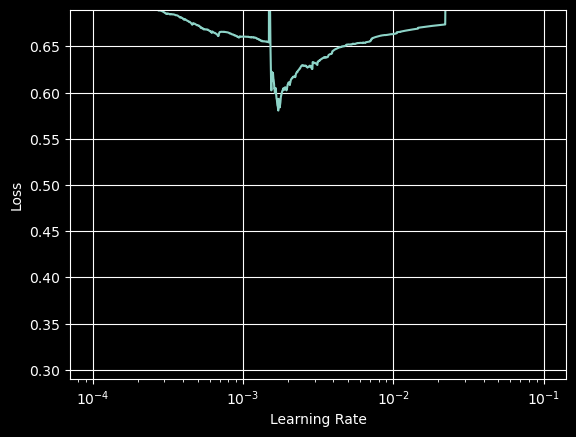

In [17]:
fig, ax = plt.subplots()

ax.plot(
    exponential__learning_rate_cb.learning_rates,
    exponential__learning_rate_cb.losses,
)
ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Loss")
ax.set_ylim(0.29, 0.69)
ax.grid(True)

In [18]:
model = make_text_model()
model.optimizer.learning_rate = 1.5e-3 / 2

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            f"models/TensorBoard/13/{strftime('run_%Y_%m_%d_%H_%M_%S')}",
            profile_batch="650,700",
        ),
    ],
)

Epoch 1/100


/opt/miniconda3/envs/homl3/lib/python3.10/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'lambda_2' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
2025-02-24 20:30:03.822286: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-02-24 20:30:03.822513: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.
2025-02-24 20:30:03.823470: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.


654/782 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5585 - loss: 0.6699

2025-02-24 20:30:27.210413: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:103] Profiler session initializing.
2025-02-24 20:30:27.210428: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:118] Profiler session started.


704/782 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5642 - loss: 0.6659

2025-02-24 20:30:28.960030: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:68] Profiler session collecting data.
2025-02-24 20:30:28.978554: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:130] Profiler session tear down.
2025-02-24 20:30:28.980446: I external/local_tsl/tsl/profiler/rpc/client/save_profile.cc:147] Collecting XSpace to repository: models/TensorBoard/13/run_2025_02_24_20_30_03/train/plugins/profile/2025_02_24_20_30_28/Edwards-MacBook-Air.local.xplane.pb


782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.5729 - loss: 0.6593 - val_accuracy: 0.8449 - val_loss: 0.4255
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.8298 - loss: 0.3866 - val_accuracy: 0.8604 - val_loss: 0.3302
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.8729 - loss: 0.3002 - val_accuracy: 0.7944 - val_loss: 0.4143
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.8955 - loss: 0.2534 - val_accuracy: 0.7881 - val_loss: 0.4558
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.9092 - loss: 0.2290 - val_accuracy: 0.7928 - val_loss: 0.4588
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.9208 - loss: 0.2056 - val_accuracy: 0.7813 - val_loss: 0.5398
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.9285 - loss: 0.1847 - val_accuracy: 0.8824 - val_loss: 0.3206
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.9350 - loss: 0.1699 - val_

In [19]:
datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

NameError: name 'tfds' is not defined